# ***LAB-09 TRADUCCION DE TEXTO CON EL LENGUAJE C++***

## NOMBRE: GONZALES SUYO FRANZ REINALDO

### DIRECCIÓN DE GITHUB: https://github.com/Gonzales-Franz-Reinaldo/SIS421-IA2/tree/main/Laboratorios/LAB-09_Traduccion_text

## 1: Importar Librerías Utilizamos el Modelo Pre-Entrenado CodeT5

In [1]:
# Importar librerías necesarias
import torch

# importando transformers para el modelo CodeT5 y el optimizador AdamW
from transformers import T5Tokenizer, T5ForConditionalGeneration, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader, random_split
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from tqdm import tqdm


In [2]:
# Montar Google Drive para cargar el dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 2: Cargamos el Dataset

In [3]:
# Cargar el dataset en formato JSON desde Google Drive
dataset_path = '/content/drive/MyDrive/SIS421/LAB-09/Traduccion_texto/dataset_traduccion.json'

with open(dataset_path, 'r') as file:
    data = json.load(file)

# Estructura del dataset
pairs = [(item['instruccion'], item['codigo']) for item in data]

In [4]:
pairs

[('Quiero realizar un contador del 1 al 10',
  'for (int i = 1; i <= 10; i++) { std::cout << i << std::endl; }'),
 ("Imprimir 'Hola Mundo'", 'std::cout << "Hola Mundo" << std::endl;'),
 ("Declarar una variable entera llamada 'x' con valor 5", 'int x = 5;'),
 ('Crear una función que reciba dos enteros y devuelva su suma',
  'int suma(int a, int b) { return a + b; }'),
 ('Realizar un bucle que sume los números del 1 al 100',
  'int suma = 0; for (int i = 1; i <= 100; i++) { suma += i; }'),
 ('Crear un bucle que imprima los números pares del 1 al 20',
  'for (int i = 2; i <= 20; i += 2) { std::cout << i << std::endl; }'),
 ('Definir una función que calcule el factorial de un número',
  'int factorial(int n) { return (n <= 1) ? 1 : n * factorial(n - 1); }'),
 ('Declarar un arreglo de 5 enteros inicializado con los valores 1, 2, 3, 4, 5',
  'int arr[5] = {1, 2, 3, 4, 5};'),
 ('Crear un bucle que imprima los elementos de un arreglo de enteros',
  'int arr[] = {1, 2, 3, 4, 5}; for (int i = 0;

## 3: Tokenización y Configuración del Dataset

In [5]:
# Importa el tokenizador de Roberta y el modelo T5
from transformers import RobertaTokenizer, T5ForConditionalGeneration

# Cargar el tokenizador de CodeT5
# secuencias de tokens que el modelo puede procesar
tokenizer = RobertaTokenizer.from_pretrained("Salesforce/codet5-small")

# Cargar el modelo CodeT5 preentrenado para generación de texto
model = T5ForConditionalGeneration.from_pretrained("Salesforce/codet5-small")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/703k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/294k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/12.5k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.57k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/242M [00:00<?, ?B/s]

In [6]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [7]:

# Configurar la longitud máxima de entrada y salida
max_input_length = 256  # Longitud máxima de la instrucción en lenguaje natural
max_output_length = 256  # Longitud máxima del código generado en C++

# Crear una clase de Dataset personalizada para el DataLoader de PyTorch
class TranslationDataset(Dataset):
    def __init__(self, pairs, tokenizer, max_input_length, max_output_length):
        # Guardar el dataset de pares (instrucción y código)
        self.pairs = pairs
        # Guardar el tokenizador
        self.tokenizer = tokenizer
        # Configurar las longitudes máximas de entrada y salida
        self.max_input_length = max_input_length
        self.max_output_length = max_output_length

    def __len__(self):
        # Retorna el número de pares en el dataset
        return len(self.pairs)

    def __getitem__(self, idx):
        # Obtiene el par de instrucción y código en el índice `idx`
        input_text, target_text = self.pairs[idx]
        # Tokeniza y ajusta la instrucción (texto de entrada)
        source = self.tokenizer.encode_plus(
            input_text,  # Texto de la instrucción en lenguaje natural
            max_length=self.max_input_length,  # Longitud máxima definida
            padding='max_length',  # Aplicar padding hasta alcanzar `max_length`
            truncation=True,  # Truncar si el texto es demasiado largo
            return_tensors="pt"  # Retornar tensores de PyTorch
        )
        # Tokeniza y ajusta el código de salida (texto objetivo)
        target = self.tokenizer.encode_plus(
            target_text,  # Texto del código en C++
            max_length=self.max_output_length,  # Longitud máxima definida
            padding='max_length',  # Padding para ajustar a `max_length`
            truncation=True,  # Truncar si el texto es demasiado largo
            return_tensors="pt"  # Retornar tensores de PyTorch
        )

        # Retorna un diccionario con las secuencias tokenizadas
        return {
            'input_ids': source['input_ids'].squeeze(),  # IDs de tokens de entrada
            'attention_mask': source['attention_mask'].squeeze(),  # Máscara de atención
            'labels': target['input_ids'].squeeze()  # IDs de tokens de salida (código)
        }


## 4: División del Dataset y Creación de DataLoaders

In [8]:
# Dividir el dataset en entrenamiento y validación
dataset = TranslationDataset(pairs, tokenizer, max_input_length, max_output_length)

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Crear DataLoaders para PyTorch
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


In [11]:
train_loader

## 5: Configuración del Optimizador, Scheduler y Parámetros de Entrenamiento

In [9]:
# Configurar el optimizador y el scheduler de tasa de aprendizaje
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.02)  # Regularización con weight decay
epochs = 15
total_steps = len(train_loader) * epochs

# Scheduler para el decaimiento de la tasa de aprendizaje
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Enviar el modelo a la GPU si está disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


- Usamos AdamW con weight_decay como regularización.
- Configuramos el scheduler para ajustar la tasa de aprendizaje linealmente a lo largo del entrenamiento.

In [10]:
import os

# Directorio para guardar checkpoints en Google Drive
checkpoint_dir = '/content/drive/MyDrive/SIS421/LAB-09/Checkpoints/'
os.makedirs(checkpoint_dir, exist_ok=True)

# Función para guardar un checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, checkpoint_dir):
    checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch_{epoch}.pth")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict()
    }, checkpoint_path)
    print(f"Checkpoint guardado: {checkpoint_path}")

# Función para cargar un checkpoint
def load_checkpoint(checkpoint_path, model, optimizer, scheduler):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Checkpoint cargado desde {checkpoint_path}, empezando desde la época {epoch + 1}")
    return epoch


## 6: Entrenamiento y Validación del Modelo  FINE-TUNING

Dentro de la función train_epoch, ocurre el ajuste real de los pesos del modelo. Aquí se realiza el fine-tuning sobre el modelo preentrenado CodeT5:


In [11]:
# Función de entrenamiento por época
def train_epoch(model, train_loader, optimizer, scheduler):
    model.train()  # Modo de entrenamiento para ajustar pesos
    train_loss = 0

    # Itera sobre cada lote de datos en el DataLoader de entrenamiento
    for batch in tqdm(train_loader, desc="Entrenamiento"):
        optimizer.zero_grad()  # Limpia los gradientes del optimizador de la iteración anterior

        # Envía los datos del lote al dispositivo (GPU o CPU)
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Realiza una pasada hacia adelante (forward) del modelo con los datos de entrada
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss  # Obtiene la pérdida calculada
        train_loss += loss.item()  # Acumula la pérdida del lote actual en la pérdida total

        # Retropropagación - ajuste de los pesos (fine-tuning)
        loss.backward()  # Calcula los gradientes con respecto a la pérdida
        optimizer.step()  # Actualiza los parámetros del modelo
        scheduler.step()  # Actualiza la tasa de aprendizaje del scheduler

    # Calcula la pérdida promedio de entrenamiento en toda la época
    avg_loss = train_loss / len(train_loader)
    return avg_loss  # Retorna la pérdida promedio





# Función de evaluación por época
def eval_epoch(model, val_loader):
    model.eval()  # Configura el modelo en modo de evaluación
    val_loss = 0  # Inicializa la pérdida de validación para esta época

    # Desactiva el cálculo de gradientes para evitar actualizaciones de parámetros
    with torch.no_grad():
        # Itera sobre cada lote de datos en el DataLoader de validación
        for batch in tqdm(val_loader, desc="Validación"):
            # Envía los datos del lote al dispositivo (GPU o CPU)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            # Realiza una pasada hacia adelante (forward) del modelo con los datos de entrada
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()  # Acumula la pérdida del lote actual en la pérdida total

    # Calcula la pérdida promedio de validación en toda la época
    avg_loss = val_loss / len(val_loader)
    return avg_loss  # Retorna la pérdida promedio



## 7: Bucle Principal de Entrenamiento y Gráficas

In [13]:
# Reanudar entrenamiento desde un checkpoint si es necesario
# Si no hay checkpoint, empezar desde la primera época

num_checkpoint_save = 5 # Para guardar el modelo cada 5 epoch

start_epoch = 0  # Inicializamos la época inicial en 0
checkpoint_path = None  # Cambia esto al archivo de checkpoint si quieres cargar un checkpoint

# Verifica si existe un checkpoint para cargar
if checkpoint_path:
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, scheduler)  # Carga el checkpoint y la última época guardada

# Listas para almacenar las pérdidas de entrenamiento y validación en cada época
train_losses, val_losses = [], []

# Bucle de entrenamiento principal, iterando desde la época de inicio hasta el total de épocas
for epoch in range(start_epoch, epochs):
    print(f"Epoch {epoch + 1}/{epochs}")  # Imprime el progreso de la época actual

    # Entrenamiento para la época actual, calcula la pérdida de entrenamiento
    train_loss = train_epoch(model, train_loader, optimizer, scheduler)

    # Validación para la época actual, calcula la pérdida de validación
    val_loss = eval_epoch(model, val_loader)

    # Almacena las pérdidas de entrenamiento y validación para esta época
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # Imprime las pérdidas de entrenamiento y validación para esta época
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}")

    # Guardar un checkpoint cada 5 épocas
    if (epoch + 1) % num_checkpoint_save == 0:
        save_checkpoint(model, optimizer, scheduler, epoch + 1, checkpoint_dir)  # Guarda el modelo, optimizador y scheduler en un checkpoint


Epoch 1/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.09it/s]


Train Loss: 0.3218
Validation Loss: 0.2390
Epoch 2/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.39it/s]


Train Loss: 0.2438
Validation Loss: 0.1843
Epoch 3/15


Validación: 100%|██████████| 20/20 [00:02<00:00,  9.80it/s]


Train Loss: 0.2058
Validation Loss: 0.1633
Epoch 4/15


Validación: 100%|██████████| 20/20 [00:02<00:00,  8.95it/s]


Train Loss: 0.1818
Validation Loss: 0.1492
Epoch 5/15


Validación: 100%|██████████| 20/20 [00:02<00:00,  9.88it/s]


Train Loss: 0.1649
Validation Loss: 0.1405
Checkpoint guardado: /content/drive/MyDrive/SIS421/LAB-09/Checkpoints/model_epoch_5.pth
Epoch 6/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.15it/s]


Train Loss: 0.1540
Validation Loss: 0.1329
Epoch 7/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Train Loss: 0.1445
Validation Loss: 0.1280
Epoch 8/15


Validación: 100%|██████████| 20/20 [00:02<00:00,  9.95it/s]


Train Loss: 0.1380
Validation Loss: 0.1239
Epoch 9/15


Validación: 100%|██████████| 20/20 [00:02<00:00,  9.96it/s]


Train Loss: 0.1335
Validation Loss: 0.1212
Epoch 10/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.17it/s]


Train Loss: 0.1312
Validation Loss: 0.1186
Checkpoint guardado: /content/drive/MyDrive/SIS421/LAB-09/Checkpoints/model_epoch_10.pth
Epoch 11/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.10it/s]


Train Loss: 0.1273
Validation Loss: 0.1168
Epoch 12/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Train Loss: 0.1255
Validation Loss: 0.1159
Epoch 13/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.31it/s]


Train Loss: 0.1245
Validation Loss: 0.1152
Epoch 14/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.35it/s]


Train Loss: 0.1235
Validation Loss: 0.1152
Epoch 15/15


Validación: 100%|██████████| 20/20 [00:01<00:00, 10.30it/s]


Train Loss: 0.1239
Validation Loss: 0.1152
Checkpoint guardado: /content/drive/MyDrive/SIS421/LAB-09/Checkpoints/model_epoch_15.pth


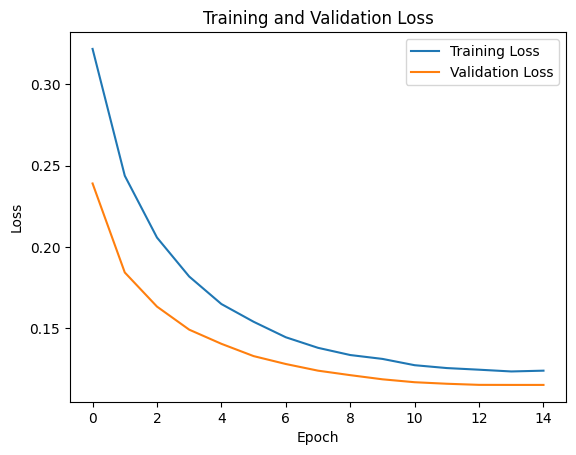

In [14]:
# Graficar las pérdidas después del entrenamiento
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()

## 8: Pruebas de Traducción con el Modelo Fine-Tuneado

In [15]:
# Cargar el último checkpoint para realizar predicciones
def load_model_for_inference(checkpoint_path, model):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.to(device)
    model.eval()
    print(f"Modelo cargado para predicción desde {checkpoint_path}")

# Ruta al checkpoint que deseas cargar
last_checkpoint = os.path.join(checkpoint_dir, "model_epoch_15.pth")  # Cambia según el checkpoint deseado
load_model_for_inference(last_checkpoint, model)

<ipython-input-15-20c6a7ccaaeb>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


Modelo cargado para predicción desde /content/drive/MyDrive/SIS421/LAB-09/Checkpoints/model_epoch_15.pth


In [16]:
model

T5ForConditionalGeneration(
  (shared): Embedding(32100, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32100, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [17]:
# Función para realizar traducciones
def translate_text(input_text, model, tokenizer, max_length=256):
    model.eval()  # Configura el modelo en modo de evaluación para desactivar capas como dropout
    with torch.no_grad():  # Desactiva el cálculo de gradientes para ahorrar memoria en inferencia
        # Tokenizar la instrucción en lenguaje natural
        input_ids = tokenizer(input_text, return_tensors="pt", max_length=max_length, truncation=True).input_ids.to(device)

        # Generar la traducción en código C++
        outputs = model.generate(input_ids, max_length=max_length, num_beams=4, early_stopping=True)

        # Decodificar los tokens generados para obtener el código en texto legible
        decoded_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

    return decoded_text  # Retorna la traducción en C++


# Pruebas con ejemplos
test_instructions = [
    "Crear un bucle que imprima los números del 1 al 10",
    "Escribir una función que calcule el factorial de un número",
    "Imprimir 'Hola, mundo!' en la consola"
]

for instruction in test_instructions:
    print("Instrucción:", instruction)  # Muestra la instrucción original
    print("Traducción en C++:")
    # Genera y muestra la traducción en C++
    print(translate_text(instruction, model, tokenizer))
    print("-" * 50)  # Línea divisoria para separar las salidas


Instrucción: Crear un bucle que imprima los números del 1 al 10
Traducción en C++:
for (int i = 1; i <= 10; i++) {
    std::cout << i << std::endl;
}
--------------------------------------------------
Instrucción: Escribir una función que calcule el factorial de un número
Traducción en C++:
for (int i = 1; i <= 2; i++) {
    std::cout << i << std::endl;
}
--------------------------------------------------
Instrucción: Imprimir 'Hola, mundo!' en la consola
Traducción en C++:
for (int i = 1; i <= 10; i++) {
    std::cout << "Hola, mundo!" << std::endl;
}
--------------------------------------------------


In [19]:
# Pruebas con ejemplos
test_instructions2 = [
    "Calcular el área de un círculo con radio 18",
    "Crear una función que convierta metros a kilómetros",
    "Escribir un programa que convierta toneladas a gramos",
    "Imprimir los primeros 10 números pares y sus cuadrados",
    "Crear una función que devuelva el valor absoluto de un número",
    "Escribir una función que determine si un número es par o impar",
    "Crear una función que reciba un número y devuelva su cuadrado"
]

for instruction in test_instructions2:
    print("Instrucción:", instruction)  # Muestra la instrucción original
    print("Traducción en C++:")
    print()
    # Genera y muestra la traducción en C++
    print(translate_text(instruction, model, tokenizer))
    print("=" * 100)


Instrucción: Calcular el área de un círculo con radio 18
Traducción en C++:

double radio = 18.0;
double area = (radio * radio) / 2;
std::cout << "El área del círculo es: " << area << std::endl;
Instrucción: Crear una función que convierta metros a kilómetros
Traducción en C++:

for (int i = 1; i <= 3; i++) {
    std::cout << metros << " metros" << std::endl;
}
Instrucción: Escribir un programa que convierta toneladas a gramos
Traducción en C++:

double toneladas = 5.0;
double gramos = toneladas * 1000;
std::cout << toneladas << " toneladas son " << gramos << " gramos" << std::endl;
Instrucción: Imprimir los primeros 10 números pares y sus cuadrados
Traducción en C++:

for (int i = 1; i <= 10; i++) {
    std::cout << i << std::endl;
}
Instrucción: Crear una función que devuelva el valor absoluto de un número
Traducción en C++:

int valorAbsoluto(int num) { return num * num; }
Instrucción: Escribir una función que determine si un número es par o impar
Traducción en C++:

for (int i = 1;